In [61]:
import sys
sys.path.append("../../py/")

In [173]:
import os
import logging
import pickle as pk
from datetime import datetime

import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import seaborn as sns

logger = logging.getLogger()
logger.setLevel(logging.INFO)

logging.basicConfig(format='%(asctime)s %(levelname)-4s %(message)s',
                    level=logging.INFO,
                    datefmt='%d-%m-%Y %H:%M:%S')

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset

from mlp import MLP

In [151]:
class EmptyPatchDataset():
    def __init__(self, patch_dataset, n_classes, class_thresholds = None):
        
        self.patch_dataset = patch_dataset
        self.patch_size = patch_dataset[0][0].shape[0]
        self.total_pixels = self.patch_size * self.patch_size
        self.class_thresholds = class_thresholds
        
        embeddings, labels, class_thresholds, pixel_counts, patch_data_idx_to_emb_idx = EmptyPatchDataset.init_from_patch_dataset(patch_dataset, 
                                                                                                  n_classes, class_thresholds)
        
        self.embeddings = embeddings
        self.labels = labels
        self.class_thresholds = class_thresholds
        self.pixel_counts = pixel_counts
        self.patch_data_idx_to_emb_idx = patch_data_idx_to_emb_idx
        self.n_classes = n_classes
        

            
    def __len__(self):
        return len(self.embeddings)
    
    def __getitem__(self, i):

        if isinstance(i, slice):
            start = i.start if i.start else 0
            stop = i.stop if i.stop else len(self.X_1)
            step = i.step if i.step else 1

            return [(self.embeddings[j], self.labels[j]) for j in range(start, stop, step)]

        return (self.embeddings[i], self.labels[i])
        
        
    @staticmethod
    def get_black_pixels(img, show = False):
        gray = cv.cvtColor(img, cv.COLOR_RGB2GRAY)
        gray = cv.GaussianBlur(gray, (3, 3), 0)
        edges = cv.Canny(gray, 50, 150)
        
        if show:
            fig, ax = plt.subplots()
            ax.imshow(edges, cmap = "binary")
            plt.show()

        black_pixels = np.where(edges == 255)
        
        return len(black_pixels[0])
    
    def get_img_class(self, img):
        black_pixels = EmptyPatchDataset.get_black_pixels(img)
    
    @staticmethod
    def get_class_thresholds(pixel_counts):
        thresholds = []
        prev_min = 0

        for partition in pixel_counts:
            thresh = np.max(partition)

            if thresh > prev_min:
                thresholds.append(thresh)
            else:
                thresholds.append(np.min(partition[partition > thresh]))
        return thresholds
    
    def plot_pixel_distribution(self, bins = 25, use_counts = False):
        fig, ax = plt.subplots()
        sns.histplot(
            data = self.pixel_counts,
            discrete = False,
            stat = "count" if use_counts else "probability",
            bins = bins,
            ax = ax
        )
        plt.show()
        
        
    @staticmethod
    def init_from_patch_dataset(patch_dataset, n_classes = 5, class_thresholds = None):
        patch_data_idx_to_emb_idx = {}
        embeddings = []
        pixel_counts = []
        
        emb_idx = 0
        Xs = [patch_dataset.X_1, patch_dataset.X_2]
        
        for i in range(len(patch_dataset)):
            for j in range(2):
                patch = Xs[j][i]
                embeddings.append(patch.patch_shift)
                pixel_counts.append(EmptyPatchDataset.get_black_pixels(patch.patch))
                patch_data_idx_to_emb_idx[emb_idx] = (i,j)
                emb_idx += 1
                
        if class_thresholds is None:
            split_pixel_counts = np.array_split(np.sort(pixel_counts), n_classes)
            class_thresholds = EmptyPatchDataset.get_class_thresholds(split_pixel_counts)
            
        labels = np.digitize(pixel_counts, class_thresholds, right=True)
        
        return embeddings, labels, class_thresholds, pixel_counts, patch_data_idx_to_emb_idx
    
    def init_validation_dataset(self, val_dataset):
        return EmptyPatchDataset(val_dataset, n_classes = self.n_classes, class_thresholds = self.class_thresholds)
    
        def save(self, file_name):
        with open(file_name, "wb") as f:
            pk.dump(self, f)

### Experiments

In [127]:
my_data = [0.79, 0.01,0.02, 0.3,0.7,0.78]
thresholds = [0.1,0.5,0.76]
np.digitize(my_data, thresholds, right=True)

array([3, 0, 0, 1, 2, 3])

In [5]:
with open("../../py/output/patch_train_dataset_128.pk", "rb") as f:
    train_data = pk.load(f)
    
with open("../../py/output/patch_val_dataset_128.pk", "rb") as f:
    val_data = pk.load(f)

In [64]:
epds = EmptyPatchDataset(val_data)

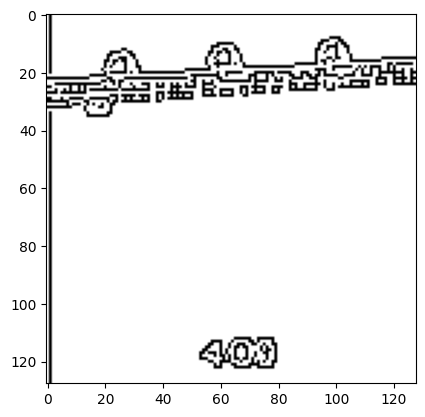

0.061279296875


In [26]:
patch = val_data.X_1[0]
img = patch.patch

#patch.show()

print(epds.get_black_pixels(img, show = True) / epds.total_pixels)

In [79]:
pixel_counts = np.array([epds.get_black_pixels(patch[i]) for i in range(2) for patch in val_data])
pixel_count_density = np.array([pixel_count / epds.total_pixels for pixel_count in pixel_counts])

In [80]:
with open("black_pixels_train.pk", "rb") as f:
    pixel_counts_train = np.array(pk.load(f))
pixel_count_train_density = np.array([pixel_count / epds.total_pixels for pixel_count in pixel_counts_train])

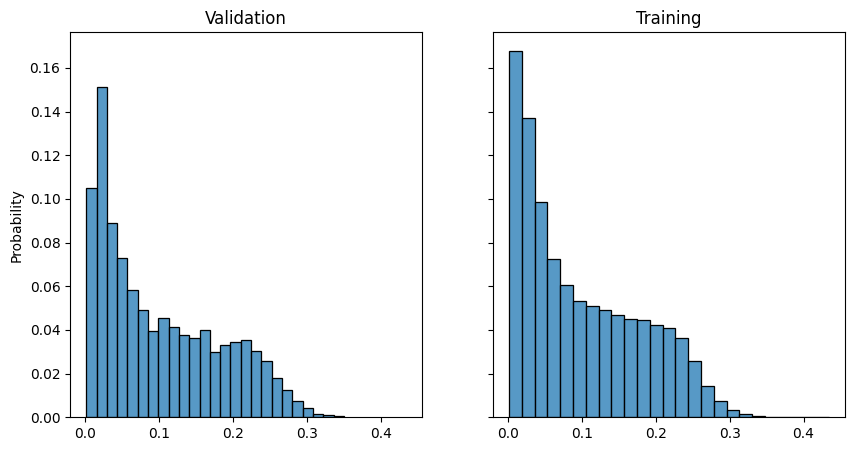

In [87]:
fig, ax = plt.subplots(1,2, figsize = (10,5), sharey = True, sharex = True)
sns.histplot(
    data=pixel_count_density,
    discrete=False,
    stat='probability',
    bins = 25,
    ax = ax[0]
)
sns.histplot(
    data=pixel_count_train_density,
    discrete=False,
    stat='probability',
    bins = 25,
    ax = ax[1]
)
ax[0].set_title("Validation")
ax[1].set_title("Training")
plt.show()

In [99]:
np.max(pixel_count_train_density)/25

0.01738525390625

In [98]:
np.linspace(0,np.max(pixel_count_train_density), 25)

array([0.        , 0.01810964, 0.03621928, 0.05432892, 0.07243856,
       0.0905482 , 0.10865784, 0.12676748, 0.14487712, 0.16298676,
       0.18109639, 0.19920603, 0.21731567, 0.23542531, 0.25353495,
       0.27164459, 0.28975423, 0.30786387, 0.32597351, 0.34408315,
       0.36219279, 0.38030243, 0.39841207, 0.41652171, 0.43463135])

In [100]:
len(pixel_count_train_density[pixel_count_train_density < 0.01810964])/len(pixel_count_train_density)




0.1627930210802612

In [105]:
split_train = np.array_split(np.sort(pixel_count_train_density), 5)

In [106]:
split_train

[array([0.00128174, 0.00128174, 0.00128174, ..., 0.02185059, 0.02185059,
        0.02185059]),
 array([0.02185059, 0.02185059, 0.02185059, ..., 0.0524292 , 0.0524292 ,
        0.0524292 ]),
 array([0.0524292 , 0.0524292 , 0.0524292 , ..., 0.10852051, 0.10852051,
        0.10852051]),
 array([0.10852051, 0.10852051, 0.10852051, ..., 0.18133545, 0.18133545,
        0.18133545]),
 array([0.18133545, 0.18133545, 0.18133545, ..., 0.43463135, 0.43463135,
        0.43463135])]

In [109]:
def get_partition_thresholds(pixel_props):
    thresholds = []
    prev_min = 0
    
    for partition in pixel_props:
        thresh = np.max(partition)
        
        if thresh > prev_min:
            thresholds.append(thresh)
        else:
            thresholds.append(np.min(partition[partition > thresh]))
    return thresholds

In [119]:
threshes = get_partition_thresholds(split_train)

prev_thresh = 0

for thresh in threshes:
    threshed = pixel_count_train_density[pixel_count_train_density>=prev_thresh]
    threshed = threshed[threshed < thresh]
    print(len(threshed))
    prev_thresh = thresh

43995
44035
44073
44056
44044


In [120]:
len(pixel_count_train_density)

220206

In [121]:
44000*5

220000

### Tests

In [129]:
with open("../../py/output/patch_train_dataset_128.pk", "rb") as f:
    train_data = pk.load(f)
    
with open("../../py/output/patch_val_dataset_128.pk", "rb") as f:
    val_data = pk.load(f)

In [152]:
epds_train = EmptyPatchDataset(train_data, n_classes = 5, class_thresholds = None)
epds_val = epds_train.init_validation_dataset(val_data)

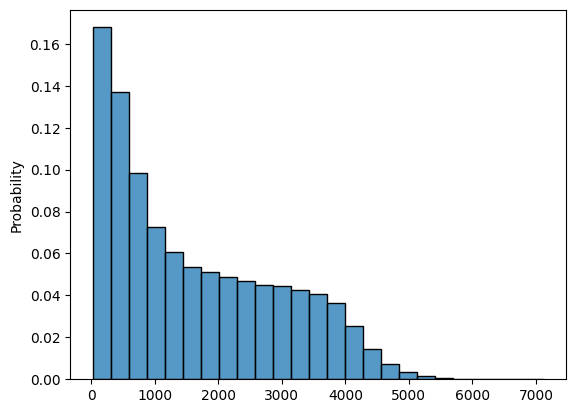

In [153]:
epds_train.plot_pixel_distribution()

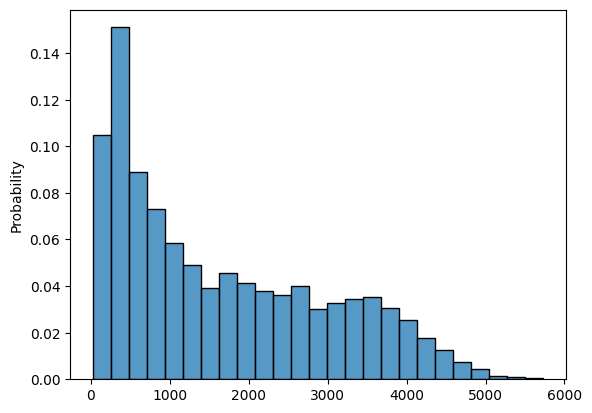

In [154]:
epds_val.plot_pixel_distribution()

In [160]:
np.array(epds_train.class_thresholds) / epds_train.total_pixels

array([0.02185059, 0.0524292 , 0.10852051, 0.18133545, 0.43463135])

In [161]:
np.array(epds_val.class_thresholds) / epds_train.total_pixels

array([0.02185059, 0.0524292 , 0.10852051, 0.18133545, 0.43463135])

### Classifier

In [174]:
class EmptyPatchClassifier(nn.Module):
    def __init__(self, first_hidden_parameters, second_hidden_parameters, output_parameters):
        super(EmptyPatchClassifier, self).__init__()
        
        self.hidden_mlp_1 = MLP(**first_hidden_parameterst_hidden_parameters)
        self.hidden_mlp_2 = MLP(**second_hidden_parameters)
        self.output_mlp = MLP(**output_parameters)
    
        self.classifier = nn.Sequential(self.hidden_mlp_1, self.hidden_mlp_2, self.output_mlp)
        
        self.criterion = nn.CrossEntropyLoss()
        self.optimiser = None
        
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        self.checkpoint = {"epoch": 0,
                           "batch": 0,
                           "model_state_dict": self.state_dict(),
                           "optimiser_state_dict": None,
                           "loss": 0,
                           "avg_batch_losses_20": [],
                           "batch_losses": [],
                           "validation_losses ": [],
                           "run_start": datetime.now().strftime("%d/%m/%Y %H:%M:%S"),
                           "run_end": None,
                           "model_kwargs": self.kwargs}
        
    def forward(self, x):
        return self.classifier(x)
    
    def predict(self, x):
        y = self.classifier(x)
        
        return np.argmax(y)
    
    def compile_optimiser(self, **kwargs):
        self.optimiser = optim.Adam(self.parameters(), **kwargs) 
        
    def get_loss(self, y_true, y_pred):
        return self.criterion(y_true, y_pred)
    
    @torch.no_grad()
    def evaluate(self, evaluation_loader, validation = True):

        eval_losses = []

        self.eval()

        for embeddings, y_true in validation_loader:
            embeddings, y_true = embeddings.to(self.device), y_true.to(self.device)
            y_pred = self.classifier(embeddings)
            val_losses.append(self.get_loss(y_true = y_true, y_pred = y_pred).cpu())

        if validation:
            self.train()
            return np.mean(val_losses)

        return val_losses
    
    def update_checkpoint(self, checkpoint_dir, batch_losses, validation_losses, **checkpoint_data):

        for k, v in checkpoint_data.items():
            if k in self.checkpoint:
                self.checkpoint[k] = v

        if checkpoint_dir is not None:

            if not os.path.isdir(checkpoint_dir):
                os.makedirs(checkpoint_dir)

            model_params_dir = os.path.join(checkpoint_dir, "empty_classifier_checkpoint.pt")
            torch.save(self.checkpoint, model_params_dir)

            batch_loss_train_dir = os.path.join(checkpoint_dir,
                                                f"batch_loss_logs_t{checkpoint_data.get('epoch', 0)}.pk")
            with open(batch_loss_train_dir, "wb") as f:
                pk.dump(batch_losses, f)

            batch_loss_validation_dir = os.path.join(checkpoint_dir,
                                                     f"batch_loss_logs_v{checkpoint_data.get('epoch', 0)}.pk")
            with open(batch_loss_validation_dir, "wb") as f:
                pk.dump(validation_losses, f)
    
    def train_model(self, train_loader, validation_loader, epochs, checkpoint_dir=None, batch_log_rate=100):

        self.to(self.device)

        for epoch in range(epochs):
            batch_losses = []
            validation_losses = []
            avg_batch_losses_20 = []

            logging.info(f"Starting Epoch: {epoch + 1}")

            for batch, (embeddings, y_true) in enumerate(train_loader):

                self.optimiser.zero_grad()

                embeddings, y_true = embeddings.to(self.device), y_true.to(self.device)
                y_pred = self.classifier(embeddings)

                loss = self.get_loss(y_true = y_true, y_pred = y_pred)

                batch_losses.append(loss.cpu().detach())

                loss.backward()
                self.optimiser.step()

                if batch % (len(train_loader) // batch_log_rate + 1) == 0 and batch != 0:
                    with torch.no_grad():
                        avg_loss = np.mean(batch_losses[-20:])
                        avg_batch_losses_20.append(avg_loss)
                        logging.info(
                            f"Epoch {epoch + 1}: [{batch + 1}/{len(train_loader)}] ---- CrossEntropy Training Loss = {avg_loss}")

                        if batch % (len(train_loader) // (batch_log_rate//4) + 1) == 0:
                            validation_loss = self.get_validation_loss(validation_loader)
                            validation_losses.append(validation_loss)
                            logging.info(
                                f"Epoch {epoch + 1}: [{batch + 1}/{len(train_loader)}] ---- CrossEntropy Validation Loss = {validation_loss}")

                        self.update_checkpoint(checkpoint_dir=checkpoint_dir,
                                               batch_losses=batch_losses,
                                               validation_losses=validation_losses,
                                               epoch=epoch,
                                               batch=batch,
                                               model_state_dict=self.state_dict(),
                                               optimiser_state_dict=self.optimiser.state_dict,
                                               loss=loss.cpu().detach(),
                                               avg_batch_losses_20=avg_batch_losses_20,
                                               run_end=datetime.now().strftime("%d/%m/%Y %H:%M:%S"))

            with torch.no_grad():
                self.update_checkpoint(checkpoint_dir=checkpoint_dir,
                                       batch_losses=batch_losses,
                                       validation_losses=validation_losses,
                                       epoch=epochs,
                                       batch=len(train_loader),
                                       model_state_dict=self.state_dict(),
                                       optimiser_state_dict=self.optimiser.state_dict,
                                       loss=loss.cpu().detach(),
                                       avg_batch_losses_20=avg_batch_losses_20,
                                       run_end=datetime.now().strftime("%d/%m/%Y %H:%M:%S"))

        return self.checkpoint